In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
reit = screen_funds('Alternatives')
commodity = screen_funds('Commodities', min_assets=.2)
print(len(reit), len(commodity))
quote = Quote(reit + commodity, 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

12 21
from 2019-04-18 to 2019-07-19 - 33


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

20


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
SGOL,60,0.184480,0.339632,0.519809,11.776669,2.692057
GLD,60,0.183655,0.337508,0.520634,11.713881,2.667662
BAR,60,0.183461,0.338235,0.518943,11.723051,2.700990
IAU,60,0.182982,0.343818,0.509122,11.702122,2.716592
PALL,60,0.148760,0.632195,0.222754,6.204893,11.245765
GLTR,60,0.143953,0.318645,0.426861,9.090907,3.584793
PSLV,60,0.143923,0.420191,0.323630,10.351201,4.805911
SIVR,60,0.101721,0.420330,0.223120,7.967032,4.517453
SLV,60,0.100141,0.422558,0.218206,7.894734,4.539009


evicted PSLV 0.761 -0.242
evicted VNQI 0.802 0.206
evicted PALL 0.271 0.128
retry backlogs ['BAR', 'SGOL', 'SCHH', 'XLRE', 'IAU', 'GLTR', 'VNQ', 'IYR', 'RWR', 'SIVR', 'USRT', 'RWO', 'SLV', 'ICF'] at 0.905/-0.51 - 0.583
evicted SLV 0.686 -0.213
retry backlogs ['SGOL', 'BAR', 'SCHH', 'XLRE', 'IAU', 'VNQ', 'IYR', 'RWR', 'SIVR', 'USRT', 'GLTR', 'RWO', 'ICF'] at 0.910/-0.52 - 0.583
evicted SIVR 0.687 -0.197
retry backlogs ['SGOL', 'BAR', 'SCHH', 'XLRE', 'IAU', 'VNQ', 'IYR', 'RWR', 'USRT', 'GLTR', 'RWO', 'ICF'] at 0.915/-0.53 - 0.583
retry backlogs ['SGOL', 'BAR', 'XLRE', 'SCHH', 'IAU', 'VNQ', 'IYR', 'RWR', 'USRT', 'GLTR', 'RWO', 'ICF'] at 0.920/-0.54 - 0.583
retry backlogs ['SGOL', 'BAR', 'XLRE', 'SCHH', 'IAU', 'VNQ', 'IYR', 'RWR', 'USRT', 'GLTR', 'RWO', 'ICF'] at 0.925/-0.55 - 0.583
retry backlogs ['SGOL', 'BAR', 'XLRE', 'SCHH', 'IAU', 'VNQ', 'IYR', 'RWR', 'USRT', 'GLTR', 'RWO', 'ICF'] at 0.930/-0.56 - 0.583
retry backlogs ['SGOL', 'BAR', 'XLRE', 'SCHH', 'IAU', 'VNQ', 'IYR', 'RWR', 'USRT',

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.121171,0.183448,-0.353117,-0.027984,0.110052,0.229371,0.528850,0.617259,7.013822,1.756466
GLD,60.0,0.183655,0.337508,-0.497640,0.000415,0.113558,0.307270,1.157343,0.520634,11.713881,2.667662
REET,60.0,0.075140,0.278301,-0.563882,-0.137137,0.105179,0.263935,0.674511,0.241476,3.514610,3.361345
DBA,60.0,0.007747,0.345991,-0.645003,-0.229567,-0.005952,0.261818,0.732414,-0.000547,-0.777042,7.053194


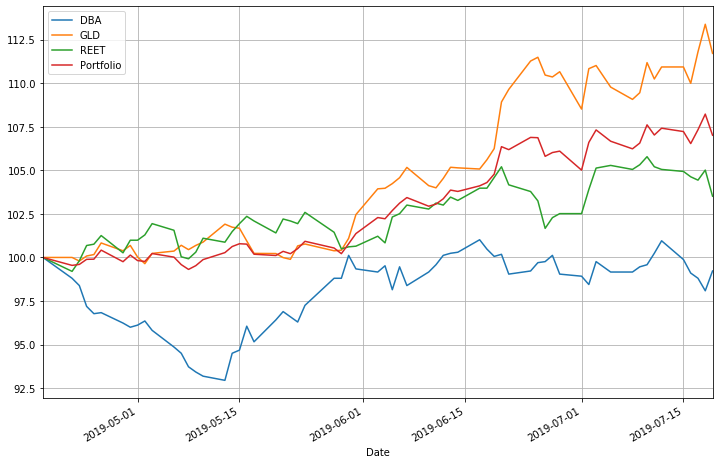

In [4]:
bounds = .08, .12
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=2, bounds=bounds)
quote.setup_mask(['DBA', 'GLD', 'REET'])
sd.update(quote.optimize_portfolio(_lambda=2, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=2, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)